# X-ray Classification
## Team Losslandscape

We classify 21165 images of X-ray images and train neural networks to classify these into 4 clases: normal(lung of healthy patients), pneumonia, covid-19 and lung-opacity. 

In this notebook we demonstrate how to train usign the CustomSqueezenet network. 

### Installing dependencies, setting up Googlecolab and importing modules


In [1]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import files
files.upload()

{}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c acse4-ml-2020
!unzip acse4-ml-2020.zip

mv: cannot stat 'kaggle.json': No such file or directory
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
acse4-ml-2020.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  acse4-ml-2020.zip
replace submission_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 



- We have our machine-learning models saved in models.py
- Our train, validate and test functions are in utils.py
- datasets.py contains the datasets TestDataset, AugmentedDataset and the preprocessing transform





In [4]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from torchvision import models, datasets, transforms

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

from utils import *  # imports validate, train, set_seed, preds_validate and more functions
from datasets import *  #imports preprocessing transform and the AugmentedDatset
from models import * #  we import our models from here

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Loading the datasets and preparing the train, validation and test sets
#### Includes data augmentation and increasing the size of dataset.

In [5]:
# Import the datasets
covid_train_full = AugmentedDataset(2, rotation = 5, scale = 0.1, hfp = 0.5, translation_h=0.03, translation_v= 0.03, foldername="/content/xray-data/xray-data")
covid_test = TestDataSet('/content/xray-data/xray-data/test', transform=preprocessing)

# Creating a training validation split that will be used for gridsearching
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(covid_train_full.samples, covid_train_full.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
print("No. of Training: ", indices[0])
print("No. of Validation: ", indices[1].shape)

# Creating the subsets for training and validation data
covid_train = Subset(covid_train_full, indices[0])
covid_validation = Subset(covid_train_full, indices[1])

test_loader = DataLoader(covid_test , batch_size=1, shuffle=False, num_workers=1, drop_last=False)
train_loader = DataLoader(covid_train, batch_size=32, shuffle=True, num_workers=6)
validation_loader = DataLoader(covid_train, batch_size=32, shuffle=True, num_workers=6)

No. of Training:  [18993 21250 11044 ...  1730 12236  7219]
No. of Validation:  (4233,)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Showing some example plots!
**Original Dataset**

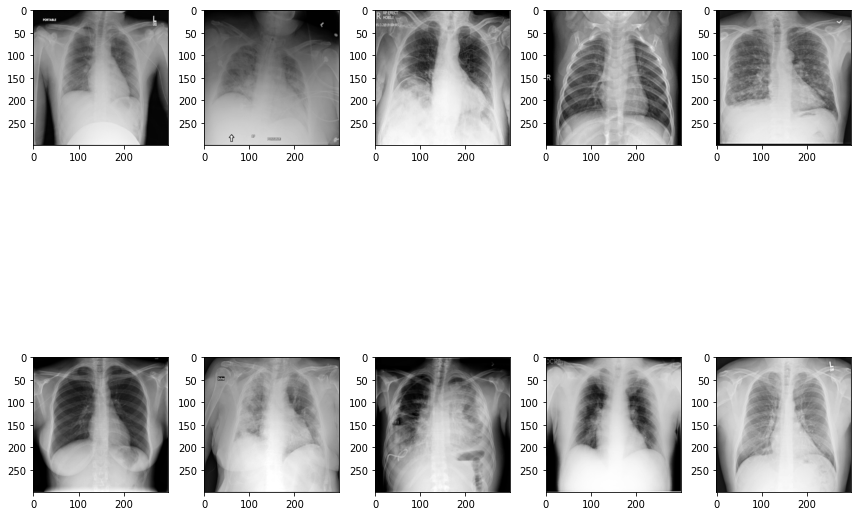

In [6]:
fig = plt.figure(figsize=(12,12))
columns = 5
rows = 2
for i in range(1,columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(covid_train_full[i][0][0], cmap = 'gray')
fig.tight_layout(pad=1)
plt.show()

**Augmented Plots**

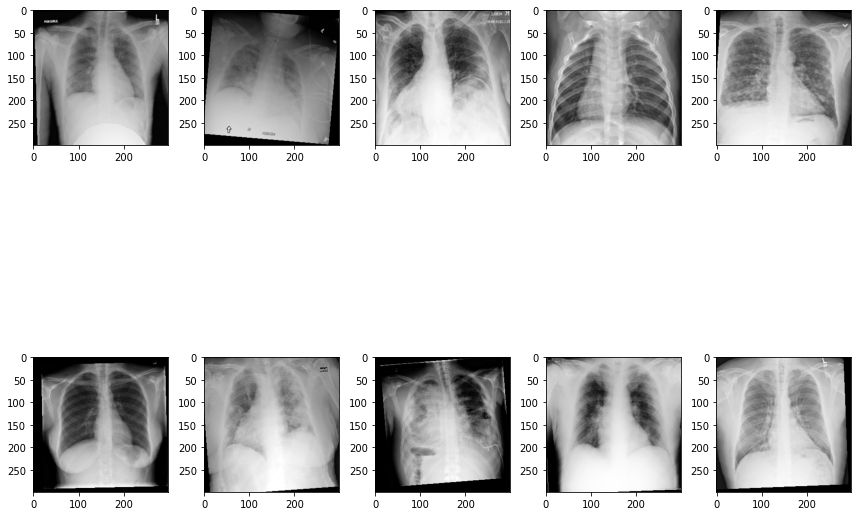

In [7]:
fig = plt.figure(figsize=(12,12))
columns = 5
rows = 2
for i in range(1,columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(covid_train_full[21165+i][0][0], cmap = 'gray')
fig.tight_layout(pad=1)
plt.show()

For these set of images, it is able to see that the images are rotated, horizontally flipped, scaled and translated. Only small alterations to the images are made to avoid noise in the training set. 

### Train our model (use CustomSqueezenet)
#### Setting parameters

These optimal parameters found by the hyperparameter optimization in the weights and biases platform

In [8]:
squeeze_batch_size = 128
squeeze_momentum = 0.9
squeeze_epochs = 5      # Just show how we work
squeeze_weight_decay = 0.001
squeeze_lr = 1e-2

set_seed(42)

True

#### Load model and create optimizer/criterion

In [9]:
# Create a CustomSqueezenet model from models.py
model = CustomSqueezenet().to(device)
# Print model structure
print(model)

# Create optimizer and criterion with the hyperparameter we choose
optimizer = torch.optim.SGD(model.parameters(), lr=squeeze_lr, weight_decay=squeeze_weight_decay, momentum=squeeze_momentum)
criterion = nn.CrossEntropyLoss()

CustomSqueezenet(
  (model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

#### Train the model and print out the evaluation data

In [26]:
def evaluate(model, data_loader, device='cpu'):
    """
    Evaluate model given labeled input data

    Args:
        model (nn.Module): Model to evaluate
        data_loader (DataLoader): DataLoader for input data
        device (str, optional): Device to use. Defaults to 'cpu'.

    Returns:
        np.array: array with predictions
        np.array: array with actual values
    """
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)


In [ ]:
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

model.train()
model = model.to(device)
liveloss = PlotLosses()
for epoch in range(squeeze_epochs):
    logs = {}
    # Train
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, device=device, imshape=(-1, 3, 299, 299))
    # Update the logs for the training data
    scheduler.step()
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    # Validate
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader, imshape=(-1, 3, 299, 299), device=device)
    y_pred, y_gt = evaluate(model, validation_loader, device=device)
    # Create confusion matrix for validation
    cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred)

    # Update the logs for the training data
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    logs['val_' + 'ROC_AUC'] = cm.AUNU
    logs['val_' + 'F1_Score'] = cm.F1_Macro

    # Plot
    liveloss.update(logs)
    liveloss.draw()

We use four indicators to evaluate our model: Accuracy, loss, ROC_AUC_Score, F1_score.

#### Print confusion matrix

In [ ]:
import seaborn as sns
# transfer ConfusionMatrix to an array
def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes:
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

y_pred, y_gt = evaluate(model, validation_loader, device=device)
print(y_pred, y_gt)
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) ## Create the confusion matrix from Data. ConfusionMatrix is a class derived from the pycm library
rcm = to_raw_matrix(cm) ## store the confusion matrix values

# Print confusion matrix
sns.heatmap(rcm, cmap="Blues", vmin=0, vmax=25, annot=True)

#### Save model

In [ ]:
!mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model

model_save_name = 'CustomSqueezenet_X_Ray_classifier.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

optimiser_save_name = 'CustomSqueezenet_X_Ray_classifier_optimiser1.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}" 
torch.save(model.state_dict(), path)

### Make predictions

In [ ]:
# Get predictions (softmax)
preds_squeeze = predict(model, test_loader, max=False, imshape=(-1, 3, 299, 299), device=device)
# Save predictions to a file
preds_to_file(preds_squeeze, "preds_squeeze.csv")